## Construction

* accuracy of vanilla model (93.5 on main dist) on cat/dog is 92.4 (lr* = 0.5)
* accuracy of model trained on just cat/dog train data is 91.3 (lr* = 1.0, epochs* = 200 (400 => 91.4))
* using 40% of cat/dog => 79.4%

steps
1. Train a model on 40% of cat/dog training examples.
2. On the remaining 60%, evaluate the model.
3. Take the 10% which is most confidently mis-predicted.

In [2]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader

from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

from ffcv.writer import DatasetWriter
from ffcv.fields import IntField, RGBImageField

In [3]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

class TransformWrapperDataset:
    def __init__(self, dset, transform):
        self.dset = dset
        self.transform = transform
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, i):
        x, y = self.dset[i]
        return self.transform(x), y

class CifarSubset:
    def __init__(self, ii, train=True, aug=None):
        self.ii = ii
        self.dset = CIFAR10('/tmp', train=train)
        
    def __len__(self):
        return len(self.ii)
    
    def __getitem__(self, i):
        return self.dset[self.ii[i]]
    
    def loader(self, bs=500):
        normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
        if self.dset.train:
            transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(32, padding=4),
                T.ToTensor(),
                normalize,
            ])
        else:
            transform = T.Compose([
                T.ToTensor(),
                normalize,
            ])
        loader = DataLoader(TransformWrapperDataset(self, transform),
                            batch_size=bs, shuffle=self.dset.train, num_workers=8)
        return loader
    
    def ffcv_loader(self, bs=500, name='tmp', aug=False, shuffle=None):
        p = f'/tmp/cifar_{name}.beton'
        if not os.path.exists(p):
            writer = DatasetWriter(p, {
                'image': RGBImageField(),
                'label': IntField()
            })  
            writer.from_indexed_dataset(self)

        device = 'cuda:0'
        label_pipeline = [IntDecoder(), ToTensor(), ToDevice(device), Squeeze()]
        image_pipeline = [SimpleRGBImageDecoder()]
        if aug:
            image_pipeline.extend([
                RandomHorizontalFlip(),
                RandomTranslate(padding=2),
    #             Cutout(12, tuple(map(int, CIFAR_MEAN))),
            ])  
        image_pipeline.extend([
            ToTensor(),
            ToDevice(device, non_blocking=True),
            ToTorchImage(),
            Convert(torch.float16),
            T.Normalize(CIFAR_MEAN, CIFAR_STD),
        ])
        if shuffle is None:
            shuffle = aug
        order_opt = OrderOption.RANDOM if shuffle else OrderOption.SEQUENTIAL
        loader = Loader(p,
                        batch_size=bs,
                        num_workers=8,
                        order=order_opt,
                        drop_last=aug,
                        pipelines={'image': image_pipeline,
                                   'label': label_pipeline})
        return loader

In [4]:
def create_model(w=1.0):

    class Mul(nn.Module):
        def __init__(self, weight):
            super().__init__()
            self.weight = weight
        def forward(self, x): 
            return x * self.weight

    class Flatten(nn.Module):
        def forward(self, x): 
            return x.view(x.size(0), -1) 

    class Residual(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, x): 
            return x + self.module(x)

    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1):
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=kernel_size, stride=stride, padding=padding,
                          bias=False),
                nn.BatchNorm2d(channels_out),
                nn.ReLU(inplace=True)
        )   

    NUM_CLASSES = 10
    w0 = int(w*64)
    w1 = int(w*128)
    w2 = int(w*256)
    model = nn.Sequential(
        conv_bn(3, w0, kernel_size=3, stride=1, padding=1),
        conv_bn(w0, w1, kernel_size=5, stride=2, padding=2),
        Residual(nn.Sequential(conv_bn(w1, w1), conv_bn(w1, w1))),
        conv_bn(w1, w2, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2),
        Residual(nn.Sequential(conv_bn(w2, w2), conv_bn(w2, w2))),
        conv_bn(w2, w1, kernel_size=3, stride=1, padding=0),
        nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        nn.Linear(w1, NUM_CLASSES, bias=False),
        Mul(0.2)
    )   
    model = model.to(memory_format=torch.channels_last)
    return model

In [5]:
def evaluate(model):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad(), autocast():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            count += len(labels)
    return correct / count

In [6]:
loss_fn = CrossEntropyLoss()

def train(epochs=200):

    # lr = 0.5
    lr = 1.0
    n_iters = epochs * len(train_loader)
    lr_schedule = np.interp(np.arange(1+n_iters), [0, n_iters], [1, 0])
    
    model = create_model(w=1.0).cuda()
    scaler = GradScaler()

    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    losses = []
    accs = []
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in train_loader:
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            losses.append(loss.item())
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        if epoch % 5 == 0:
            acc = evaluate(model)
            accs.append(acc)
    plt.figure(figsize=(3, 2))
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    plt.figure(figsize=(3, 2))
    plt.title('acc')
    plt.plot(accs)
    plt.show()
    return model

In [7]:
## cat/dog test-set
tgt = torch.tensor(CIFAR10('/tmp', train=False).targets)
mask = (tgt == 3) | (tgt == 5)
ii = torch.arange(10000)[mask]
# test_loader = CifarSubset(ii, train=False).loader()
test_loader = CifarSubset(ii, train=False).ffcv_loader(name='catdog_test')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 19935.14it/s]


In [8]:
## cat/dog train-set
tgt = torch.tensor(CIFAR10('/tmp', train=True).targets)
mask = (tgt == 3) | (tgt == 5)
ii = torch.arange(50000)[mask]
# train_loader = CifarSubset(ii, train=True).ffcv_loader(name='catdog_train', aug=True)
train_loader = CifarSubset(ii[:1500], train=True).ffcv_loader(name='catdog_train_15p', aug=True) # first 15%

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 14961.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.79it/s]


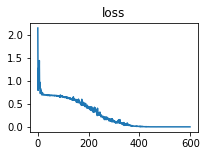

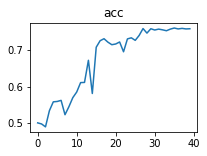

acc: 0.00038


In [9]:
model0 = train()
print('acc:', evaluate(model0))

In [18]:
print('acc:', evaluate(model0))

acc: 0.76


In [10]:
## use data augmentation too
train_loader = CifarSubset(ii[1500:], train=True).ffcv_loader(name='catdog_train_85p', aug=True, shuffle=False)
outputs_l = []
labels_l = []
model = model0
model.eval()
k = 20
for _ in tqdm(range(k)):
    with torch.no_grad(), autocast():
        for inputs, labels in train_loader:
            outputs = model(inputs.cuda())
            outputs_l.append(outputs.cpu())
            labels_l.append(labels.clone().cpu())
outputs = torch.cat(outputs_l).reshape(k, -1, outputs_l[0].size(-1)).mean(0)
labels = torch.cat(labels_l).reshape(k, -1)[0]
deltas = outputs[:, 5] - outputs[:, 3]
y_pred = (deltas > 0)
y_true = (labels == 5)
conf_correct = deltas * (2 * y_true.float() - 1)
(y_pred == y_true).float().mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.75it/s]


tensor(0.7506)

In [11]:
mask = (conf_correct < -3)
print(mask.float().mean(), mask.sum())

ii1 = ii[1500:][mask]
train_loader = CifarSubset(ii1, train=True).ffcv_loader(name='catdog_train_85p_wrong3', aug=True)
# print(pd.Series(tgt[ii1]).value_counts())

tensor(0.1362) tensor(1158)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1158/1158 [00:00<00:00, 11551.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.74it/s]


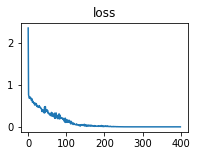

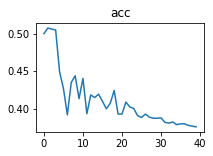

In [12]:
model2 = train(epochs=200)

In [17]:
evaluate(model2)

0.3765

In [14]:
scores = []
def viz(y_score=None):
    y_true1 = y_true.float()
    plt.figure(figsize=(5, 5))
    if y_score is not None:
        scores.append(y_score)
    plt.plot([0, 1], [1, 0])
    plt.scatter([0.5, 0.5], [0.5, 0.5])
    for y_score in scores:
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_score)
        plt.plot(tpr, 1-fpr)
        y_pred = (y_score > 0).float()
        tpr0 = (y_pred * y_true1).sum() / y_true1.sum()
        tnr0 = ((1 - y_pred) * (1 - y_true1)).sum() / (1 - y_true1).sum()
        plt.scatter([tpr0], [tnr0])
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.title('ROC curve')
    plt.show()

In [15]:
outputs_l = []
labels_l = []
model = model2
model.eval()
with torch.no_grad(), autocast():
    for inputs, labels in test_loader:
        outputs = model(inputs.cuda())
        outputs_l.append(outputs.cpu())
        labels_l.append(labels.clone().cpu())
outputs = torch.cat(outputs_l)
labels = torch.cat(labels_l)
deltas = outputs[:, 5] - outputs[:, 3]
y_pred = (deltas > 0)
y_true = (labels == 5)
(y_pred == y_true).float().mean()

tensor(0.3765)

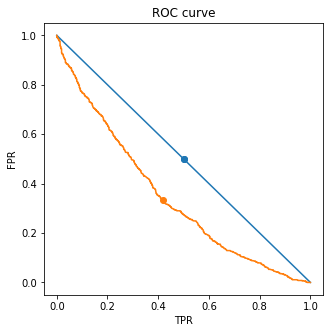

In [16]:
viz(deltas)